In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score

from numpy.random import random
from scipy.stats import norm
from scipy.stats import multivariate_normal

import sci_palettes
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
sci_palettes.register_cmap()
sns.set_palette('aaas')
np.random.seed(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Color palettes

In [2]:
bias_palette = ['#4DBBD5', '#8491B4', '#3C5488']
gene_types_palette = ['#BC3C29', '#20854E']
continuous_palette_6_items = list(sns.color_palette('flare').as_hex())

# Functions for generation of validation sets, prioritization results under different assumptions

Prioritization results for prioritization models with different performance levels  - perfect, average and bad. Models differ in distribution of score for disease and non-disease genes.

The number of all disease genes can be stated using ```M``` parameter.

In [3]:
def rvs_unit_interval_normal(loc, scale, size):
    rvs = norm.rvs(loc=loc, scale=scale, size=100)
    rvs = rvs[(rvs >= 0) & (rvs <= 1)]
    return rvs

def get_prioritization_results(model_type, M=2000):    
    df = pd.DataFrame(index=[f'gene_{i+1}' for i in range(20000)])

    df['label'] = 0
    df.loc[np.random.choice(df.index, M, replace=False), 'label'] = 1

    if model_type == 'perfect':
        df['score'] = [np.random.random()/4 + 0.75 if v == 1 else np.random.random()/4 
                       for v in df['label']]
    elif model_type == 'average':
        df['score'] = [rvs_unit_interval_normal(1,0.4,1)[0] if v == 1 else rvs_unit_interval_normal(0,0.4,1)[0] 
                       for v in df['label']]
    elif model_type == 'bad':
        df['score'] = [rvs_unit_interval_normal(1,0.6,1)[0] if v == 1 else rvs_unit_interval_normal(0,0.6,1)[0] 
                       for v in df['label']]

    df = df.sort_values('score', ascending=False)
    df['rank'] = range(1, len(df)+1)
    
    return df

Generation of validation sets from disease genes with different validation bias. Validation bias is encoded by different propensity score - when the bias is high, highly ranked genes are more likely to appear in validation sets.

In [4]:
def get_validation_sets(ranked_disease_genes, bias, vaild_set_size, number_of_sets):
    ranks = range(1,len(ranked_disease_genes)+1)
    if bias_level == 0:
        probs = np.array([1. for r in ranks])
    elif bias_level == 1:
        probs = np.array([norm.pdf(r, loc=0, scale=700) for r in ranks])
    elif bias_level == 2:
        probs = np.array([norm.pdf(r, loc=0, scale=300) for r in ranks])
    else:
        print('Wrong bias level')
        return
    
    probs /= probs.sum()
    
    valid_sets = [np.random.choice(ranked_disease_genes, vaild_set_size, replace=False, p=probs) for _ in range(number_of_sets)]
    return valid_sets

Sampling of validation sets that are contaminated with non-disease genes. Genes are sampled uniformly from disease and non-disease genes according to the specified level of contamination

In [5]:
def get_contaminated_validation_sets(ranked_disease_genes, nondisease_genes, vaild_set_size, contamination_level, number_of_sets):
    N_incorrect_genes = int(vaild_set_size * contamination_level)
    N_correct_genes = vaild_set_size - N_incorrect_genes
    
    valid_sets = [np.concatenate([np.random.choice(ranked_disease_genes, N_correct_genes, replace=False),
                                  np.random.choice(nondisease_genes, N_incorrect_genes, replace=False)]) 
                  for _ in range(number_of_sets)]
    return valid_sets

# Metrics that are used

Average Disease Gene Rank, AUC ROC, pAUC ROC, recall@k are used for simulations.

In [6]:
def average_disease_gene_rank(prioritization, validation_set):
    return prioritization.loc[validation_set]['rank'].mean()

def auc_roc(prioritization, validation_set):
    assigned_labels = pd.Series(0, index=prioritization.index)
    assigned_labels.loc[validation_set] = 1
    return roc_auc_score(assigned_labels, prioritization['score'])

def pauc_roc(prioritization, validation_set, max_fpr=0.02):
    assigned_labels = pd.Series(0, index=prioritization.index)
    assigned_labels.loc[validation_set] = 1
    return roc_auc_score(assigned_labels, prioritization['score'], max_fpr=max_fpr)

def recall_at_k(prioritization, validation_set, k=300):
    TP = len(prioritization.iloc[:k, :].index.intersection(validation_set))
    return TP / len(validation_set)

# Example of validation bias detection for the perfect model

Initially we need to state the assumptions about the validation process.

```M``` - the total number of disease genes

```performance``` - the true model performance level

```metric_info``` - information about the metrics we use

```bias_levels``` - validation vias level

```validation_set_size``` - validation set size

If we want to choose a range of assumptions to see how performance estimates distributions would change - we can assign a list of assumptions to later iterate over it.

In [7]:
M = 2000
performance = 'perfect'
prioritization = get_prioritization_results(performance, M)

metric_info = {'avg_rank': {'function': average_disease_gene_rank, 
                            'parameters': {}},
               'auc_roc': {'function': auc_roc, 
                           'parameters': {}},
               'pauc_roc': {'function': pauc_roc, 
                            'parameters': {'max_fpr': 0.02}},
               'recall_at_k': {'function': recall_at_k, 
                               'parameters': {'k': 300}}
              }

number_of_sets = 1000
bias_levels = [0,1,2]
validation_set_size = 100

simulated_metrics = {metric: {bias_level:[] for bias_level in bias_levels} for metric in metric_info}
simulated_thresholds = {metric: {} for metric in metric_info}

Here we iterate over validation bias levels.

For each level we generate 10000 validation sets of size 100. Then, for each validation set we compute all of the performance metric values and store them in a dictionary. 

In [8]:
for bias_level in bias_levels:
    assumption = bias_level
    
    ranked_disease_genes = prioritization.query('label == 1').sort_values('rank').index
    valid_sets = get_validation_sets(ranked_disease_genes, bias_level, validation_set_size, number_of_sets)

    for valid in valid_sets:
        for metric in metric_info:
            estimate = metric_info[metric]['function'](prioritization, valid, **metric_info[metric]['parameters'])
            simulated_metrics[metric][assumption].append(estimate)

    for metric in metric_info:
        if metric in ['avg_rank']:
            simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.05)
        else:
            simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.95)

Now we can plot distributions of perfromance estimates for different sets of assumptions

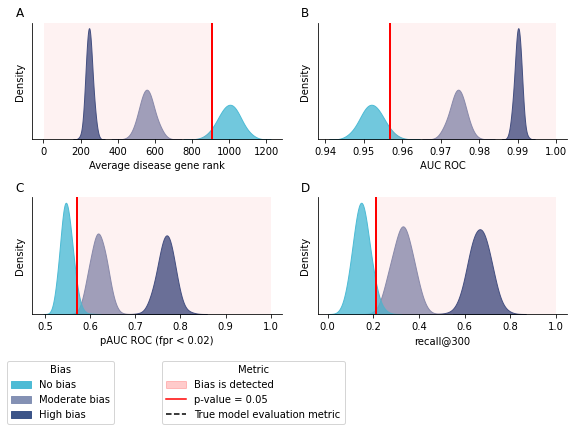

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8,5))

metric_full_names = {'avg_rank': 'Average disease gene rank',
                     'auc_roc': 'AUC ROC',
                     'pauc_roc': f'pAUC ROC (fpr < {metric_info["pauc_roc"]["parameters"]["max_fpr"]})',
                     'recall_at_k': f'recall@{metric_info["recall_at_k"]["parameters"]["k"]}'
                    }
metric_UBs = {metric: (pd.DataFrame(simulated_metrics[metric])
                       .melt()
                       .assign(variable=lambda df: df.variable.replace({0: 'No bias', 
                                                                        1: 'Moderate bias', 
                                                                        2: 'High bias'}))
                       .set_axis(['Validation bias', metric_full_names[metric]], axis='columns')
                      ) for metric in metric_info}

for i, metric in enumerate(metric_info):
    ax = axes[i//2,i%2]
    sns.kdeplot(ax=ax,
                data=metric_UBs[metric], 
                hue='Validation bias', 
                x=metric_full_names[metric], 
                fill=True, legend=False, alpha=0.8, bw_adjust=2, linewidth=1, 
                palette=bias_palette)

    ax.axvline(simulated_thresholds[metric][0], color='red', linewidth=2)
    if metric in ['avg_rank']:
        ax.axvspan(1, simulated_thresholds[metric][0], alpha=0.05, linewidth=2)
    else:
        ax.axvspan(simulated_thresholds[metric][0], 1, alpha=0.05, linewidth=2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(yticks=[])

    ax.set_title('ABCD'[i], x=-0.05)

        

legend_bias = [mpatches.Patch(color=color) for color in bias_palette]
legend_metric = [mpatches.Patch(color='red', alpha=0.2, label='Bias is detected'),
                 Line2D([0],[0], linestyle='-', color='red', label='p-value = 0.05'), 
                 Line2D([0],[0], linestyle='--', color='black', label='True metric value')]
fig.legend(legend_bias, 
           ['No bias', 'Moderate bias', 'High bias'], 
           bbox_to_anchor=(0.2, 0), title='Bias')
fig.legend(legend_metric, 
           ['Bias is detected', 'p-value = 0.05', 'True model evaluation metric'], 
           bbox_to_anchor=(0.6, 0), title='Metric')

fig.tight_layout()

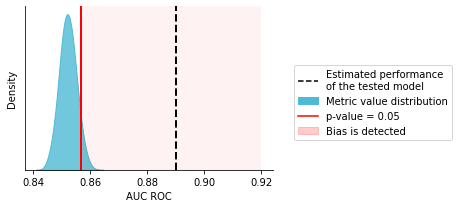

In [10]:
df = metric_UBs['auc_roc'].query('`Validation bias` == "No bias"').copy()
df['AUC ROC'] -= 0.1

fig, ax = plt.subplots(figsize=(4,3))

metric = 'auc_roc'
sns.kdeplot(ax=ax,
            data=df, 
            x=metric_full_names[metric], 
            fill=True, legend=False, alpha=0.8, bw_adjust=2, linewidth=1, 
            color=bias_palette[0])

ax.axvline(simulated_thresholds[metric][0]-0.1, color='red', linewidth=2)
ax.axvspan(simulated_thresholds[metric][0]-0.1, 0.92, alpha=0.05, linewidth=2)

ax.axvline(0.89, color='black', linestyle='--', linewidth=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(yticks=[])
        
legend_metric = [Line2D([0],[0], linestyle='--', color='black', label='True metric value'),
                 mpatches.Patch(color=bias_palette[0], label='No bias'), 
                 Line2D([0],[0], linestyle='-', color='red', label='p-value = 0.05'), 
                 mpatches.Patch(color='red', alpha=0.2, label='Bias is detected')]
fig.legend(legend_metric, 
           ['Estimated performance\nof the tested model', 'Metric value distribution', 'p-value = 0.05', 'Bias is detected'], 
           bbox_to_anchor=(1.6, 0.7))


fig.tight_layout()

# Effect of validation bias on the performance estimate for two models of different quality

In [11]:
M = 2000
performances = ['perfect', 'average', 'bad']
prioritizations = [get_prioritization_results(performance, M) for performance in performances] 

metric_info = {'avg_rank': {'function': average_disease_gene_rank, 
                            'parameters': {}},
               'auc_roc': {'function': auc_roc, 
                           'parameters': {}},
               'pauc_roc': {'function': pauc_roc, 
                            'parameters': {'max_fpr': 0.02}},
               'recall_at_k': {'function': recall_at_k, 
                               'parameters': {'k': 300}}
              }

number_of_sets = 1000
bias_levels = [0,1,2]
validation_set_size = 100

varying_assumptions = [(bias_level, performance) for bias_level in bias_levels for performance in performances]
simulated_metrics = {metric: {assumption:[] for assumption in varying_assumptions} for metric in metric_info}
simulated_thresholds = {metric: {} for metric in metric_info}

In [12]:
for bias_level in bias_levels:
    for performance, prioritization in zip(performances, prioritizations):
        assumption = (bias_level, performance)
        
        ranked_disease_genes = prioritization.query('label == 1').sort_values('rank').index
        valid_sets = get_validation_sets(ranked_disease_genes, bias_level, validation_set_size, number_of_sets)

        for valid in valid_sets:
            for metric in metric_info:
                estimate = metric_info[metric]['function'](prioritization, valid, **metric_info[metric]['parameters'])
                simulated_metrics[metric][assumption].append(estimate)

        for metric in metric_info:
            if metric in ['avg_rank']:
                simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.05)
            else:
                simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.95)

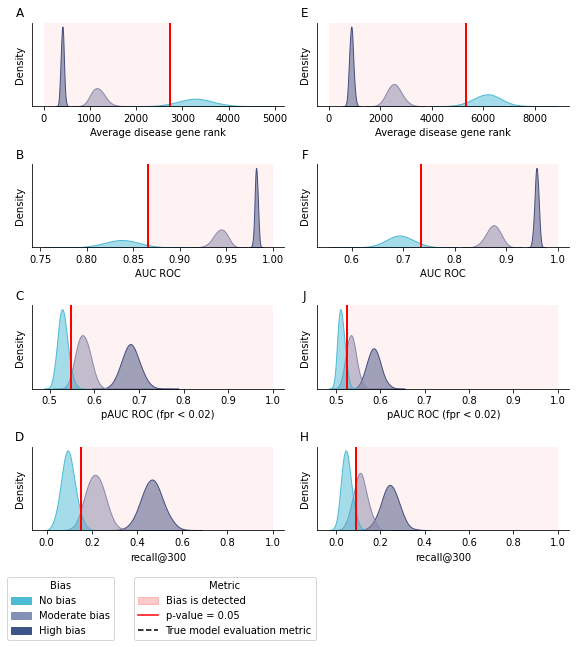

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(8,8))

metric_full_names = {'avg_rank': 'Average disease gene rank',
                     'auc_roc': 'AUC ROC',
                     'pauc_roc': f'pAUC ROC (fpr < {metric_info["pauc_roc"]["parameters"]["max_fpr"]})',
                     'recall_at_k': f'recall@{metric_info["recall_at_k"]["parameters"]["k"]}'
                    }
metric_UBs = {metric: (pd.DataFrame(simulated_metrics[metric])
                       .melt()
                       .assign(variable_0=lambda df: df.variable_0.replace({0: 'No bias', 
                                                                            1: 'Moderate bias', 
                                                                            2: 'High bias'}))
                       .set_axis(['Validation bias', 'Performance', metric_full_names[metric]], axis='columns')
                      ) for metric in metric_info}

for i, metric in enumerate(metric_info):
    for j, performance in enumerate(['average', 'bad']):
        ax = axes[i, j]
        sns.kdeplot(ax=ax,
                    data=metric_UBs[metric].query(f'Performance == "{performance}"'), 
                    hue='Validation bias', 
                    x=metric_full_names[metric], 
                    fill=True, legend=False, alpha=0.5, bw_adjust=2, linewidth=1, 
                    palette=bias_palette)

        ax.axvline(simulated_thresholds[metric][(0, performance)], color='red', linewidth=2)
        if metric in ['avg_rank']:
            ax.axvspan(1, simulated_thresholds[metric][(0, performance)], alpha=0.05, linewidth=2)
        else:
            ax.axvspan(simulated_thresholds[metric][(0, performance)], 1, alpha=0.05, linewidth=2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set(yticks=[])

        ax.set_title('ABCDEFJH'[i+j*4], x=-0.05)

        

legend_bias = [mpatches.Patch(color=color) for color in bias_palette]
legend_metric = [mpatches.Patch(color='red', alpha=0.2, label='Bias is detected'),
                 Line2D([0],[0], linestyle='-', color='red', label='p-value = 0.05'), 
                 Line2D([0],[0], linestyle='--', color='black', label='True metric value')]
fig.legend(legend_bias, 
           ['No bias', 'Moderate bias', 'High bias'], 
           bbox_to_anchor=(0.2, 0), title='Bias')
fig.legend(legend_metric, 
           ['Bias is detected', 'p-value = 0.05', 'True model evaluation metric'], 
           bbox_to_anchor=(0.55, 0), title='Metric')

fig.tight_layout()

# Effect of the assumed total number of disease genes on the validation bias detection

In [14]:
Ms = [500, 1000, 1500, 2000, 3000, 5000]
performance = 'perfect'
prioritizations = [get_prioritization_results(performance, M=M) for M in Ms]

metric_info = {'avg_rank': {'function': average_disease_gene_rank, 
                            'parameters': {}},
               'auc_roc': {'function': auc_roc, 
                           'parameters': {}},
               'pauc_roc': {'function': pauc_roc, 
                            'parameters': {'max_fpr': 0.02}},
               'recall_at_k': {'function': recall_at_k, 
                               'parameters': {'k': 300}}
              }

number_of_sets = 1000
bias_level = 0
validation_set_size = 100

simulated_metrics = {metric: {M:[] for M in Ms} for metric in metric_info}
simulated_thresholds = {metric: {} for metric in metric_info}

In [15]:
for M, prioritization in zip(Ms, prioritizations):
    assumption = M
    
    ranked_disease_genes = prioritization.query('label == 1').sort_values('rank').index
    validation_sets = get_validation_sets(ranked_disease_genes, bias_level, validation_set_size, number_of_sets)

    for validation_set in validation_sets:
        for metric in metric_info:
            estimate = metric_info[metric]['function'](prioritization, validation_set, **metric_info[metric]['parameters'])
            simulated_metrics[metric][assumption].append(estimate)

    for metric in metric_info:
        if metric in ['avg_rank']:
            simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.05)
        else:
            simulated_thresholds[metric][assumption] = np.quantile(simulated_metrics[metric][assumption], 0.95)

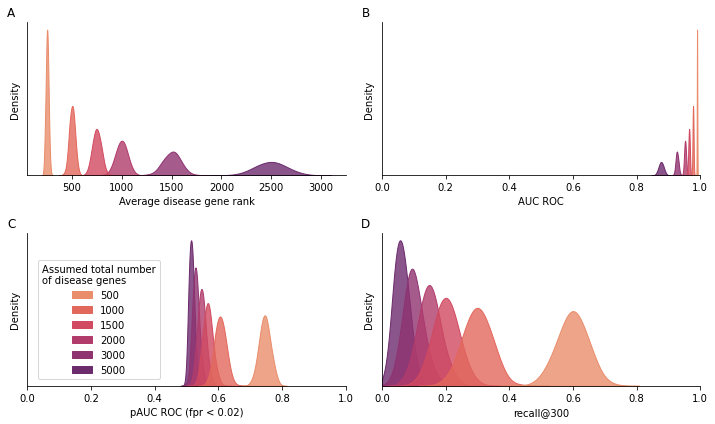

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10,6))

metric_full_names = {'avg_rank': 'Average disease gene rank',
                     'auc_roc': 'AUC ROC',
                     'pauc_roc': f'pAUC ROC (fpr < {metric_info["pauc_roc"]["parameters"]["max_fpr"]})',
                     'recall_at_k': f'recall@{metric_info["recall_at_k"]["parameters"]["k"]}'
                    }
metric_UBs = {metric: (pd.DataFrame(simulated_metrics[metric])
                       .melt()
                       .set_axis(['Assumed total number\nof disease genes', 
                                  metric_full_names[metric]], axis='columns')
                      ) for metric in metric_info}

for i, metric in enumerate(metric_info):
    ax = axes[i//2,i%2]
    sns.kdeplot(ax=ax,
                data=metric_UBs[metric], 
                hue='Assumed total number\nof disease genes', 
                x=metric_full_names[metric], 
                fill=True, legend=False, alpha=0.8, bw_adjust=2, linewidth=1, 
                palette=continuous_palette_6_items)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(yticks=[])
    if metric != 'avg_rank':
        ax.set(xlim=[0,1])
        
    ax.set_title('ABCD'[i], x=-0.05)



legend_M = [mpatches.Patch(color=continuous_palette_6_items[i]) for i in range(len(Ms))]
fig.legend(legend_M, Ms, bbox_to_anchor=(0.23, 0.4), title='Assumed total number\nof disease genes')

fig.tight_layout()

# Effect of the validation set size on the performance estimation using different metrics

In [17]:
M = 2000
performance = 'perfect'
prioritization = get_prioritization_results(performance, M)

metric_info = {'avg_rank': {'function': average_disease_gene_rank, 
                            'parameters': {}},
               'auc_roc': {'function': auc_roc, 
                           'parameters': {}},
               'pauc_roc': {'function': pauc_roc, 
                            'parameters': {'max_fpr': 0.02}},
               'recall_at_k': {'function': recall_at_k, 
                               'parameters': {'k': 300}}
              }

number_of_sets = 1000
bias_level = 0
validation_set_sizes = [20, 50, 100, 200, 350, 500]

simulated_metrics = {metric: {validation_set_size:[] for validation_set_size in validation_set_sizes} for metric in metric_info}
simulated_means = {metric: {} for metric in metric_info}
true_performance = {}

In [18]:
for validation_set_size in validation_set_sizes:
    assumption = validation_set_size
    
    ranked_disease_genes = prioritization.query('label == 1').sort_values('rank').index
    validation_sets = get_validation_sets(ranked_disease_genes, bias_level, validation_set_size, number_of_sets)

    for validation_set in validation_sets:
        for metric in metric_info:
            estimate = metric_info[metric]['function'](prioritization, validation_set, **metric_info[metric]['parameters'])
            simulated_metrics[metric][assumption].append(estimate)

    for metric in metric_info:
        simulated_means[metric][assumption] = np.mean(simulated_metrics[metric][assumption])

In [19]:
for metric in metric_info:
    true_performance[metric] = metric_info[metric]['function'](prioritization, prioritization.query('label == 1').index, 
                                                               **metric_info[metric]['parameters'])

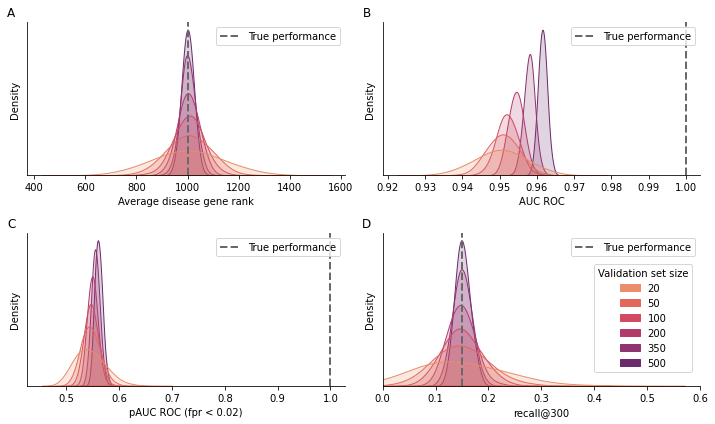

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10,6))

metric_full_names = {'avg_rank': 'Average disease gene rank',
                     'auc_roc': 'AUC ROC',
                     'pauc_roc': f'pAUC ROC (fpr < {metric_info["pauc_roc"]["parameters"]["max_fpr"]})',
                     'recall_at_k': f'recall@{metric_info["recall_at_k"]["parameters"]["k"]}'
                    }
metric_UBs = {metric: (pd.DataFrame(simulated_metrics[metric])
                       .melt()
                       .set_axis(['Validation set size', 
                                  metric_full_names[metric]], axis='columns')
                      ) for metric in metric_info}

for i, metric in enumerate(metric_info):
    ax = axes[i//2,i%2]
    
    sns.kdeplot(ax=ax,
                data=metric_UBs[metric], 
                hue='Validation set size', 
                x=metric_full_names[metric], 
                fill=True, legend=False, alpha=0.2, bw_adjust=2, linewidth=1, 
                palette=continuous_palette_6_items)
    
    ax.axvline(true_performance[metric], color='dimgray', label='True performance', linewidth=2, linestyle='--')
    ax.legend(loc=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(yticks=[])
    
    if metric == 'recall_at_k':
        ax.set(xlim=[0, 0.6])
    ax.set_title('ABCD'[i], x=-0.05)



legend_validation_set_size = [mpatches.Patch(color=color) for color in continuous_palette_6_items]
fig.legend(legend_validation_set_size, validation_set_sizes, 
           bbox_to_anchor=(0.97, 0.39), title='Validation set size')

fig.tight_layout()